# Real-Time E-commerce Data Pipeline with Spark ETL

## Project Overview

For my project, I will design and implement an ETL (Extract, Transform, Load) pipeline for a hypothetical e-commerce platform named ShopEase. This platform generates massive amounts of data daily, including user interactions, transactions, and inventory updates. My task is to process this data using Apache Spark to derive meaningful insights and support real-time analytics.


## Scenario

**ShopEase** aims to enhance its data analytics capabilities to improve user experience, optimize inventory management, and increase sales. The data generated includes:

- **User Activity Logs:** Clickstream data capturing user interactions on the website.
- **Transaction Records:** Details of purchases, refunds, and returns.
- **Inventory Updates:** Information about stock levels, restocks, and product information changes.
- **Customer Feedback:** Reviews and ratings provided by customers.

The company requires a robust ETL pipeline to process this data, perform transformations, and make it available for analytics and reporting in both batch and real-time modes.


## Project Requirements

### 1. Data Ingestion
- **Batch Data:**
  - Load historical data from large CSV and JSON files stored in your local file system.
- **Real-Time Data:**
  - Simulate and ingest streaming data representing live user activity logs.

### 2. Data Processing and Transformation
- **Using RDDs:**
  - Perform a transformation to filter out any corrupted or incomplete records from the transaction data.
  - Implement a custom transformation to anonymize user IDs for privacy compliance.
- **Using DataFrames:**
  - Clean and standardize inventory data (e.g., handling missing values, normalizing text).
  - Join user activity logs with transaction records to analyze user behavior leading to purchases.
- **Using Spark SQL:**
  - Create temporary views and execute SQL queries to compute:
    - Top 10 most purchased products in the last month.
    - Monthly revenue trends.
    - Inventory turnover rates.

### 3. Real-Time Streaming Processing (Optional but Recommended)
- Set up a Spark Streaming job to process incoming user activity logs.
- Compute real-time metrics such as:
  - Active users per minute.
  - Real-time conversion rates.
  - Detect and alert on unusual spikes in specific user activities.

### 4. Data Storage
- Store the transformed data into appropriate storage systems:
  - Use Parquet format for batch-processed data in a local data lake.
  - Use an in-memory data store like Redis or a database like PostgreSQL for real-time metrics.

### 5. Performance Optimization
- Optimize Spark jobs for better performance by:
  - Caching intermediate DataFrames where necessary.
  - Tuning Spark configurations (e.g., partition sizes, executor memory).
  - Using appropriate join strategies.

### 6. Documentation and Reporting
- Document the ETL pipeline architecture.
- Provide sample dashboards or reports (using Spark's built-in visualization) showcasing the insights derived.


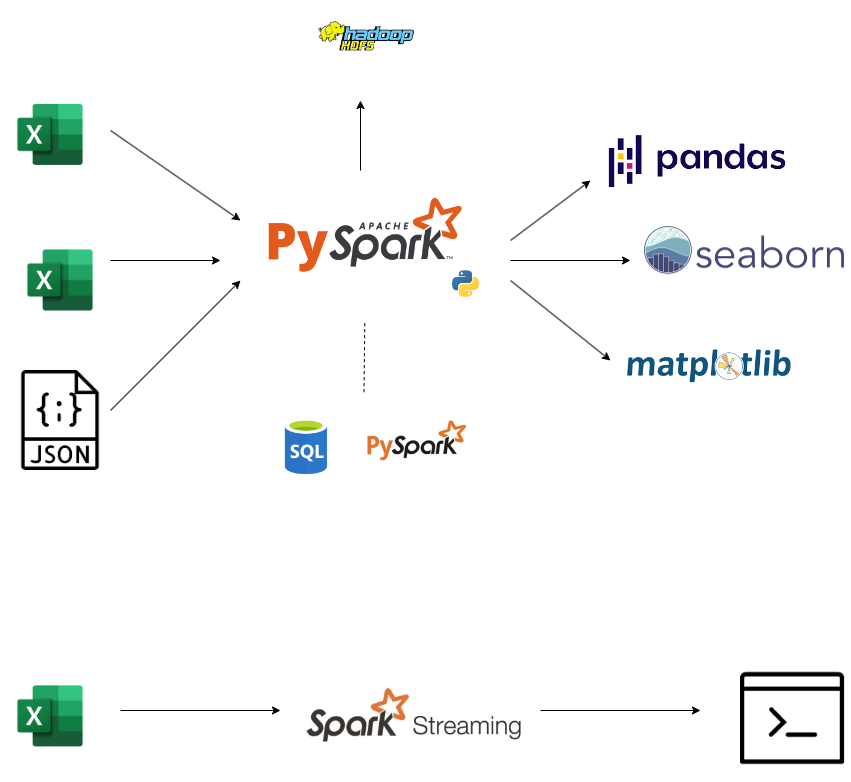

In [2]:
# Step 1: Data Ingestion - Load Large Datasets
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder.appName("ShopEase ETL Pipeline")\
            .getOrCreate()

# Load large transactions data
transactions_df =spark.read.csv("/user/student/transactions.csv",header=True)

# Load large customer feedback data
feedback_df = spark.read.csv("/user/student/customer_feedback.csv",header=True)
#Display the schema of each dataset
transactions_df.printSchema()
feedback_df.printSchema()
# Display a sample of each dataset
transactions_df.show(5)
feedback_df.show(5)

root
 |-- transaction_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- transaction_date: string (nullable = true)

root
 |-- user_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- review: string (nullable = true)
 |-- review_date: string (nullable = true)

+--------------+-------+----------+--------+------+----------------+
|transaction_id|user_id|product_id|quantity|amount|transaction_date|
+--------------+-------+----------+--------+------+----------------+
|             1|   5388|      9152|       9|305.67|      2023-01-07|
|             2|  31656|      5763|       1|184.31|      2023-05-16|
|             3|  36725|      4733|       4|  7.66|      2023-01-20|
|             4|  22713|      4207|       1|411.73|      2023-04-19|
|             5|  74067|      1914|       5|499.21| 

In [3]:
# Load invenntory dataset
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType

# Define schema for inventory data
inventory_schema = StructType([
    StructField("product_id", IntegerType(), True),
    StructField("product_name", StringType(), True),
    StructField("stock_level", IntegerType(), True),
    StructField("price", DoubleType(), True)
])

# Load JSON data with schema
inventory_df = spark.read.schema(inventory_schema).option('multiline', True).json("/user/student/inventory.json")

# Print schema and display sample data
inventory_df.printSchema()
inventory_df.show(5)

root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- stock_level: integer (nullable = true)
 |-- price: double (nullable = true)

+----------+------------+-----------+------+
|product_id|product_name|stock_level| price|
+----------+------------+-----------+------+
|         1|   Product_1|         61| 91.89|
|         2|   Product_2|        553|  9.75|
|         3|   Product_3|        328|182.89|
|         4|   Product_4|        347|148.38|
|         5|   Product_5|        180| 78.17|
+----------+------------+-----------+------+
only showing top 5 rows



In [4]:
# Step 2: Data Cleaning and Transformation with RDDs
# Convert transactions DataFrame to RDD
transactions_rdd = transactions_df.rdd

# print(f"Number of Rows Before Cleaning {transactions_rdd.count()}")
# transactions_rdd.take(5)


# Filter out corrupted records (e.g., missing transaction_id or amount)
cleaned_rdd = transactions_rdd.filter(lambda row: row[0] is not None and row[4] is not None)
cleaned_rdd.take(5)

# print(f"Number of Rows After Cleaning {transactions_rdd.count()}") # NO empty cells for all columns 
 
# Write Function to Anonymize user IDs using Hashing
def anonymize(record):
    transaction_id,user_id,product_id,quantity,amount,transaction_date= record
    anonymized_user_id = f'user_{user_id}'  # Anonymize user_id
    return (transaction_id,anonymized_user_id,product_id,quantity,amount,transaction_date)

# Apply anonymization
anonymized_rdd = cleaned_rdd.map(anonymize)

# Define schema for the DataFrame
schema = StructType([
    StructField("transaction_id", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("product_id", StringType(),True),
    StructField("quantity", StringType(), True),
    StructField("amount", StringType(), True),
    StructField("transaction_date", StringType(), True)
])

# Convert RDD to DataFrame with schema
cleaned_transactions_df = spark.createDataFrame(anonymized_rdd, schema)

# Display cleaned and anonymized data
cleaned_transactions_df.show(5)

+--------------+----------+----------+--------+------+----------------+
|transaction_id|   user_id|product_id|quantity|amount|transaction_date|
+--------------+----------+----------+--------+------+----------------+
|             1| user_5388|      9152|       9|305.67|      2023-01-07|
|             2|user_31656|      5763|       1|184.31|      2023-05-16|
|             3|user_36725|      4733|       4|  7.66|      2023-01-20|
|             4|user_22713|      4207|       1|411.73|      2023-04-19|
|             5|user_74067|      1914|       5|499.21|      2023-08-17|
+--------------+----------+----------+--------+------+----------------+
only showing top 5 rows



In [5]:
# Step 3: DataFrame Operations for Cleaning and Transformation
from pyspark.sql.functions import col, lower, trim

# Clean inventory data by handling missing values and normalizing text
cleaned_inventory_df = inventory_df.dropna(subset=["stock_level"]) \
                                  .withColumn("product_name", lower(trim(col("product_name"))))

# Display cleaned inventory data
cleaned_inventory_df.show(5)

# Perform a join operation to combine data
joined_df = cleaned_inventory_df.join(cleaned_transactions_df , on="product_id" , how="left")

# Display joined DataFrame
joined_df.show(5)

+----------+------------+-----------+------+
|product_id|product_name|stock_level| price|
+----------+------------+-----------+------+
|         1|   product_1|         61| 91.89|
|         2|   product_2|        553|  9.75|
|         3|   product_3|        328|182.89|
|         4|   product_4|        347|148.38|
|         5|   product_5|        180| 78.17|
+----------+------------+-----------+------+
only showing top 5 rows



+----------+------------+-----------+------+--------------+----------+--------+------+----------------+
|product_id|product_name|stock_level| price|transaction_id|   user_id|quantity|amount|transaction_date|
+----------+------------+-----------+------+--------------+----------+--------+------+----------------+
|       148| product_148|        892|476.44|          1954|user_88516|       9|351.44|      2023-09-02|
|       148| product_148|        892|476.44|         19568|user_10552|       1|227.87|      2023-05-24|
|       148| product_148|        892|476.44|         26688|user_29625|       2|173.65|      2023-08-06|
|       148| product_148|        892|476.44|         29594|user_41537|       9|201.17|      2023-06-01|
|       148| product_148|        892|476.44|         45513|user_14738|       3| 67.91|      2023-03-11|
+----------+------------+-----------+------+--------------+----------+--------+------+----------------+
only showing top 5 rows



In [6]:
# Step 4: Spark SQL Queries
from pyspark.sql.functions import current_date, date_sub
# Create temporary views for SQL queries
cleaned_transactions_df.createOrReplaceTempView("transactions")
cleaned_inventory_df.createOrReplaceTempView("inventory")
joined_df.createOrReplaceTempView("joined_data")

# Query: Top 10 most purchased products in the last month
top_products_df = spark.sql("""
WITH max_date AS (
    SELECT 
        MAX(year(transaction_date)) AS max_year,
        MAX(month(transaction_date)) AS max_month
    FROM 
        joined_data
)
SELECT 
    product_id, 
    product_name, 
    COUNT(*) AS number_of_purchasing
FROM 
    joined_data
WHERE 
    year(transaction_date) = (SELECT max_year FROM max_date)
    AND month(transaction_date) = (SELECT max_month FROM max_date)
GROUP BY 
    product_id, 
    product_name
ORDER BY 
    number_of_purchasing DESC
LIMIT 10
""") 
top_products_df.show()

+----------+------------+--------------------+
|product_id|product_name|number_of_purchasing|
+----------+------------+--------------------+
|       629| product_629|                  22|
|      4590|product_4590|                  21|
|       127| product_127|                  20|
|      7350|product_7350|                  20|
|      8334|product_8334|                  20|
|      6795|product_6795|                  19|
|      3673|product_3673|                  19|
|      5229|product_5229|                  19|
|      1754|product_1754|                  19|
|      1733|product_1733|                  19|
+----------+------------+--------------------+



In [7]:
# Query: Monthly revenue trends
monthly_revenue_df = spark.sql("""
    WITH MonthlyRevenue AS (
        SELECT 
            product_id, 
            product_name, 
            YEAR(transaction_date) AS year,
            MONTH(transaction_date) AS month,
            SUM(amount) AS total_revenue
        FROM 
            joined_data
        GROUP BY 
            product_id, 
            product_name, 
            YEAR(transaction_date),
            MONTH(transaction_date)
    ),
    RankedProducts AS (
        SELECT 
            product_id, 
            product_name, 
            year, 
            month, 
            total_revenue,
            ROW_NUMBER() OVER (PARTITION BY year, month ORDER BY total_revenue DESC) AS rank
        FROM 
            MonthlyRevenue
    )
    SELECT 
        product_id, 
        product_name, 
        year, 
        month, 
        total_revenue
    FROM 
        RankedProducts
    WHERE 
        rank <= 5 
""")
# This query return top 5 products Ranking beased on total_ revenue to explore trend products monthly 

monthly_revenue_df.show()

+----------+------------+----+-----+------------------+
|product_id|product_name|year|month|     total_revenue|
+----------+------------+----+-----+------------------+
|       174| product_174|2023|    8|           6370.97|
|      3018|product_3018|2023|    8|6208.9800000000005|
|      9389|product_9389|2023|    8| 6119.190000000001|
|      9345|product_9345|2023|    8|           6035.61|
|      2538|product_2538|2023|    8|           5931.99|
|      6358|product_6358|2023|    9|            5587.4|
|       891| product_891|2023|    9|            5426.0|
|      5920|product_5920|2023|    9|           5379.52|
|      6153|product_6153|2023|    9| 5342.579999999999|
|      7121|product_7121|2023|    9|5307.9400000000005|
|      1625|product_1625|2023|    7| 6646.669999999999|
|      1689|product_1689|2023|    7|5771.4800000000005|
|       807| product_807|2023|    7|           5681.72|
|      1654|product_1654|2023|    7|           5595.03|
|      8879|product_8879|2023|    7| 5514.240000

In [8]:
# Query: Inventory turnover rates
# Inventory turnover is the rate that inventory stock is sold, or used, and replaced. 
# The inventory turnover ratio is calculated by dividing the cost of goods by average inventory for the same period. 
# A higher ratio tends to point to strong sales and a lower one to weak sales
turnover_rate_df = spark.sql("""
WITH total_sales AS (
    SELECT 
        product_id,
        SUM(quantity) AS total_quantity_sold
    FROM transactions
    GROUP BY product_id
),

avg_inventory AS (
    SELECT
        product_id,
        AVG(stock_level) AS average_inventory
    FROM inventory
    GROUP BY product_id
),

cogs AS (
    SELECT 
        product_id,
        SUM(amount) AS total_revenue
    FROM transactions
    GROUP BY product_id
)

SELECT
    t.product_id,
    COALESCE(c.total_revenue, 0) / COALESCE(i.average_inventory, 0) AS inventory_turnover_rate
FROM
    total_sales t
    LEFT JOIN avg_inventory i ON t.product_id = i.product_id
    LEFT JOIN cogs c ON t.product_id = c.product_id
ORDER BY inventory_turnover_rate DESC

""")
turnover_rate_df.show()

+----------+-----------------------+
|product_id|inventory_turnover_rate|
+----------+-----------------------+
|      7567|     30000.179999999997|
|      2871|     29058.729999999996|
|      9501|               28807.18|
|      4373|     27230.920000000002|
|      7759|     26989.679999999997|
|      1284|               26472.62|
|      3135|     24224.690000000002|
|      1467|     24153.539999999997|
|        40|               22390.04|
|      2821|               21368.41|
|      6771|     20911.020000000004|
|      9021|     20415.170000000002|
|      9503|               13467.14|
|      8049|               13461.41|
|      3636|              11995.145|
|      6706|               11198.25|
|      3494|              11162.055|
|      2458|     11078.715000000002|
|      8268|               11039.83|
|      7405|      9644.616666666665|
+----------+-----------------------+
only showing top 20 rows



In [14]:
# Step 5: Real-Time Processing (Optional)
from pyspark.sql.functions import window, approx_count_distinct
from pyspark.sql.types import StructType, StructField, StringType, TimestampType

# Define the schema with correct types, especially for the timestamp column
schema = StructType([
    StructField("transaction_id", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("product_id", StringType(), True),
    StructField("quantity", StringType(), True),
    StructField("amount", StringType(), True),
    StructField("transaction_date", TimestampType(), True)  # Assuming this is a timestamp field
])

# Create a streaming DataFrame from the CSV file
streaming_transactions_df = spark.readStream \
    .option("header", "true") \
    .schema(schema) \
    .csv("/user/student/transactions/")

# Compute approximate active users per minute using a time window
active_users = streaming_transactions_df \
    .groupBy(window(streaming_transactions_df.transaction_date, "1 minute")) \
    .agg(approx_count_distinct("user_id").alias("active_users"))

# Write the result to the console for real-time monitoring
query = active_users.writeStream \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", "false") \
    .start()

# Keep the stream running, but terminate if no new data arrives for 10 seconds
query.awaitTermination(10)

2024-09-06 04:04:15,210 WARN streaming.StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-9c6c7801-a253-4e0a-9d80-0abec7c5ede5. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


False

-------------------------------------------
Batch: 0
-------------------------------------------
+------------------------------------------+------------+
|window                                    |active_users|
+------------------------------------------+------------+
|{2023-07-09 00:00:00, 2023-07-09 00:01:00}|2728        |
|{2023-09-20 00:00:00, 2023-09-20 00:01:00}|2673        |
|{2023-06-04 00:00:00, 2023-06-04 00:01:00}|2907        |
|{2023-01-25 00:00:00, 2023-01-25 00:01:00}|2941        |
|{2023-06-25 00:00:00, 2023-06-25 00:01:00}|2609        |
|{2023-11-28 00:00:00, 2023-11-28 00:01:00}|2735        |
|{2023-08-17 00:00:00, 2023-08-17 00:01:00}|2809        |
|{2023-08-09 00:00:00, 2023-08-09 00:01:00}|2622        |
|{2023-08-19 00:00:00, 2023-08-19 00:01:00}|2682        |
|{2023-12-04 00:00:00, 2023-12-04 00:01:00}|2659        |
|{2023-01-12 00:00:00, 2023-01-12 00:01:00}|2769        |
|{2023-06-01 00:00:00, 2023-06-01 00:01:00}|2944        |
|{2023-11-20 00:00:00, 2023-11-20

In [15]:
# Step 6: Performance Optimization Techniques
from pyspark.sql.functions import broadcast
# Caching DataFrames to optimize performance for multiple transformations
cleaned_transactions_df.cache()
feedback_df.cache()
cleaned_inventory_df.cache()
# Repartition DataFrames for optimal join performance
print("Initial number of partitions in cleaned_transaction_df:", cleaned_transactions_df.rdd.getNumPartitions())
print("Initial number of partitions in cleaned_inventory_df:", cleaned_inventory_df.rdd.getNumPartitions())

transactions_df_repartitioned = cleaned_transactions_df.repartition("transaction_id")
inventory_df_repartitioned =cleaned_inventory_df.repartition("product_id")

print("Initial number of partitions in transactions_df_repartitioned:", transactions_df_repartitioned.rdd.getNumPartitions())
print("Initial number of partitions in inventory_df_repartitioned:", inventory_df_repartitioned.rdd.getNumPartitions())

# Use Broadcast Join for small DataFrames (if applicable)
joined_df_optimized =cleaned_inventory_df.join(broadcast(cleaned_transactions_df), on="product_id" , how="inner")


# Display the optimized joined DataFrame
joined_df_optimized.show(5)

Initial number of partitions in cleaned_transaction_df: 6
Initial number of partitions in cleaned_inventory_df: 1
Initial number of partitions in transactions_df_repartitioned: 200
Initial number of partitions in inventory_df_repartitioned: 200


+----------+------------+-----------+-----+--------------+----------+--------+------+----------------+
|product_id|product_name|stock_level|price|transaction_id|   user_id|quantity|amount|transaction_date|
+----------+------------+-----------+-----+--------------+----------+--------+------+----------------+
|         1|   product_1|         61|91.89|        984357|user_62830|       9|364.85|      2023-03-22|
|         1|   product_1|         61|91.89|        980450|user_46977|       3| 96.42|      2023-11-27|
|         1|   product_1|         61|91.89|        979066|user_43659|      10|405.26|      2023-06-17|
|         1|   product_1|         61|91.89|        974301|user_54157|       3|156.87|      2023-01-27|
|         1|   product_1|         61|91.89|        967207|user_32903|      10|141.47|      2023-02-10|
+----------+------------+-----------+-----+--------------+----------+--------+------+----------------+
only showing top 5 rows



In [19]:
# Step 7: Store the Transformed Data
# Store the cleaned and transformed data in Parquet format
# Define the paths for saving the Parquet files
transactions_path = "/user/student/cleaned_transactions.parquet"
inventory_path = "/user/student/cleaned_inventory.parquet"
joined_data_path = "/user/student/joined_data.parquet"

# Save the cleaned and transformed data in Parquet format
cleaned_transactions_df.write \
    .mode("overwrite") \
    .parquet(transactions_path)

cleaned_inventory_df.write \
    .mode("overwrite") \
    .parquet(inventory_path)

joined_df_optimized.write \
    .mode("overwrite") \
    .parquet(joined_data_path)

## Sample Dashboard Outputs
- **Top Products Bar Chart:** Displaying the top 10 products with the highest sales.
- **Revenue Trend Line Chart:** Showing monthly revenue over the past year.
- **Inventory Turnover Heatmap:** Visualizing turnover rates across different product categories.

*(Include actual screenshots or detailed descriptions as appropriate.)*


In [41]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [42]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 1.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


### 1. Top Products Bar Chart - Displaying the top 10 products with the highest sales

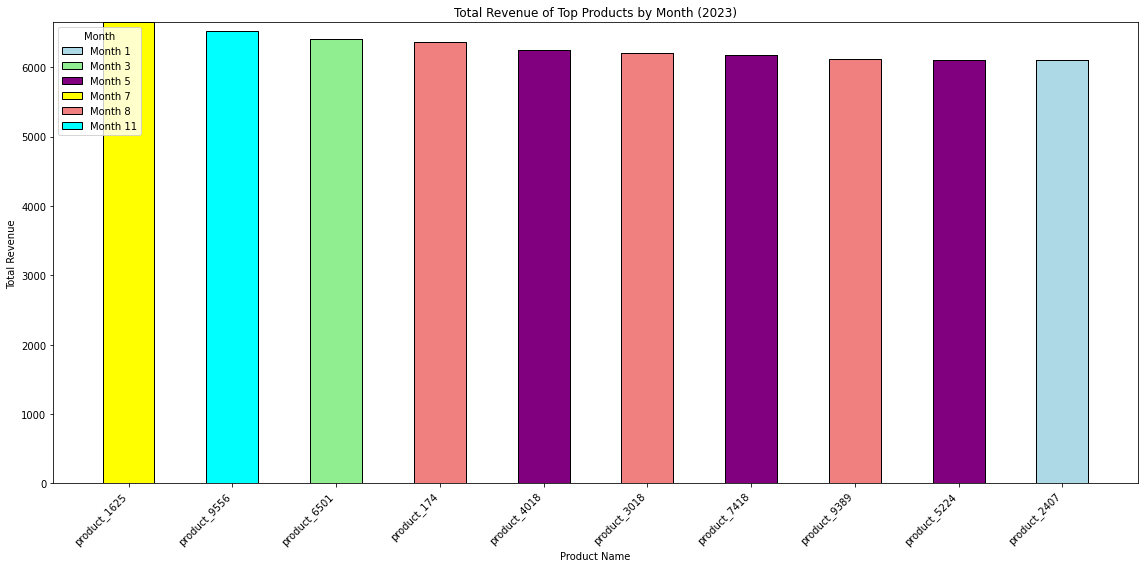

In [9]:
import matplotlib.pyplot as plt
import numpy as np
top_products_pd =monthly_revenue_df.toPandas()
# Ensure the DataFrame is sorted by 'total_revenue'
top_products_pd = top_products_pd.sort_values(by='total_revenue', ascending=False)

# Select top N products (adjust N as needed)
top_n = 10  # Display only the top 10 products
top_products_pd = top_products_pd.head(top_n)

# Create a list of unique products and months
unique_products = top_products_pd['product_name'].unique()
unique_months = sorted(top_products_pd['month'].unique())

# Create a mapping for month colors
colors = {
    1: 'lightblue',   # January
    2: 'pink',        # February
    3: 'lightgreen',  # March
    4: 'orange',      # April
    5: 'purple',      # May
    6: 'skyblue',     # June
    7: 'yellow',      # July
    8: 'lightcoral',  # August
    9: 'green',       # September
    10: 'salmon',     # October
    11: 'cyan',       # November
    12: 'gold'        # December
}

# Create a figure with an appropriate size
plt.figure(figsize=(16, 8))

# Set bar width
bar_width = 0.5

# Position of the bars on x-axis
positions = np.arange(len(unique_products))

# Initialize an array for the bottom of the bars
bottoms = np.zeros(len(unique_products))

# Plot bars for each month
for month in unique_months:
    # Filter data for the current month
    month_data = top_products_pd[top_products_pd['month'] == month]
    
    # Get the revenue values for products in that month
    revenues = month_data.set_index('product_name')['total_revenue']
    
    # Get revenue values for plotting
    month_revenues = [revenues.get(p, 0) for p in unique_products]
    
    # Plot stacked bars
    plt.bar(positions, month_revenues, bar_width, color=colors[month], label=f'Month {month}', edgecolor='black', bottom=bottoms)
    
    # Update bottoms for stacking
    bottoms += month_revenues

# Add labels and title
plt.xlabel('Product Name')
plt.ylabel('Total Revenue')
plt.title('Total Revenue of Top Products by Month (2023)')
plt.xticks(positions, unique_products, rotation=45, ha='right')
plt.legend(title='Month')

# Show the plot
plt.tight_layout()
plt.show()

### 2. Revenue Trend Line Chart - Showing monthly revenue over the past year

/tmp/ipykernel_5165/3035923344.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


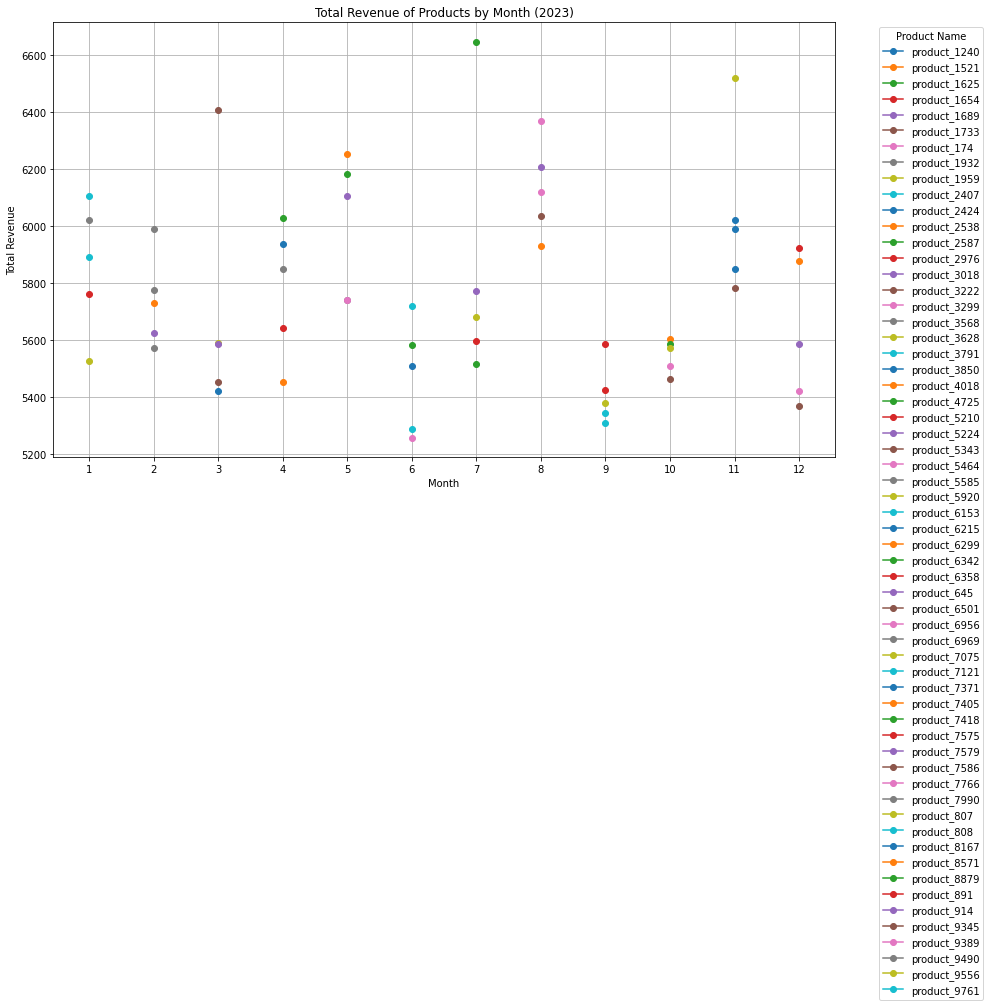

In [10]:
df=monthly_revenue_df.toPandas()
# Pivot the DataFrame to get months as index and products as columns
pivot_df = df.pivot(index='month', columns='product_name', values='total_revenue')

# Plotting
plt.figure(figsize=(14, 8))

# Plot each product's total revenue as a line
for product in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[product], marker='o', label=product)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.title('Total Revenue of Products by Month (2023)')
plt.xticks(pivot_df.index)  # Ensure all months are shown on x-axis
plt.legend(title='Product Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.grid()
plt.show()

### 3. Inventory Turnover Heatmap - Visualizing turnover rates across different product categories


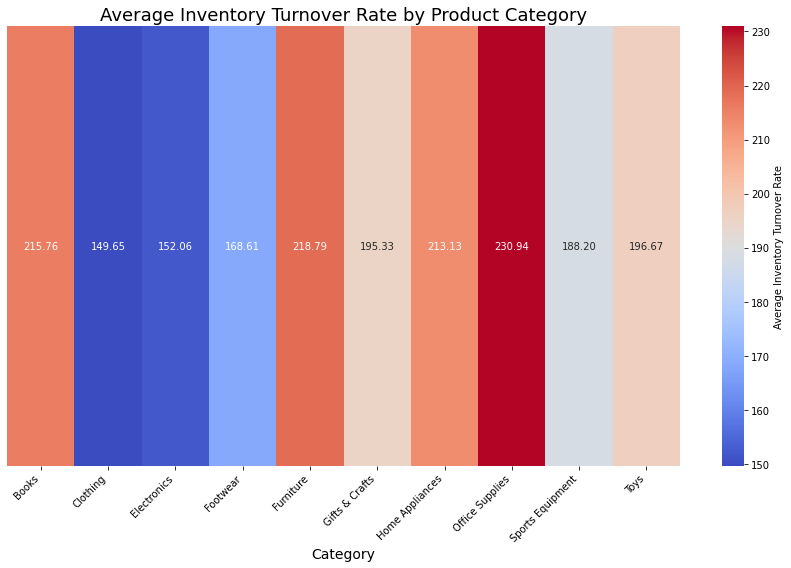

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

# Define the list of categories
categories = ['Electronics', 'Home Appliances', 'Furniture', 'Office Supplies', 'Clothing', 'Footwear', 'Toys', 
              'Books', 'Sports Equipment', 'Gifts & Crafts']

# Function to randomly assign a category
def assign_random_category(product_id):
    return random.choice(categories)

# Create DataFrame with product IDs
product_ids = pd.DataFrame({'product_id': range(1, 10001)})

# Assign random categories
product_ids['category'] = product_ids['product_id'].apply(assign_random_category)

# Ensure product_id is of the same type
product_df = inventory_df.toPandas()  
turnover_df = turnover_rate_df.toPandas()  

product_df['product_id'] = product_df['product_id'].astype(int)
turnover_df['product_id'] = turnover_df['product_id'].astype(int)

# Merge the category data
product_df = product_df.merge(product_ids, on='product_id', how='left')
merged_df = product_df.merge(turnover_df, on='product_id', how='left')

# Handle missing categories
merged_df['category'].fillna('Unknown', inplace=True)

# Group by category and calculate the average turnover rate for each category
category_turnover_avg = merged_df.groupby('category')['inventory_turnover_rate'].mean().reset_index()

# Plotting the heatmap for average turnover rate by category
plt.figure(figsize=(12, 8))
sns.heatmap(category_turnover_avg.set_index('category').T, annot=True, fmt=".2f", cmap='coolwarm', 
            cbar_kws={'label': 'Average Inventory Turnover Rate'})

# Rotate the x-axis labels for readability
plt.xticks(rotation=45, ha='right')
plt.yticks([])  # Remove y-axis ticks as it's a transposed row

# Add titles and labels
plt.title('Average Inventory Turnover Rate by Product Category', fontsize=18)
plt.xlabel('Category', fontsize=14)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

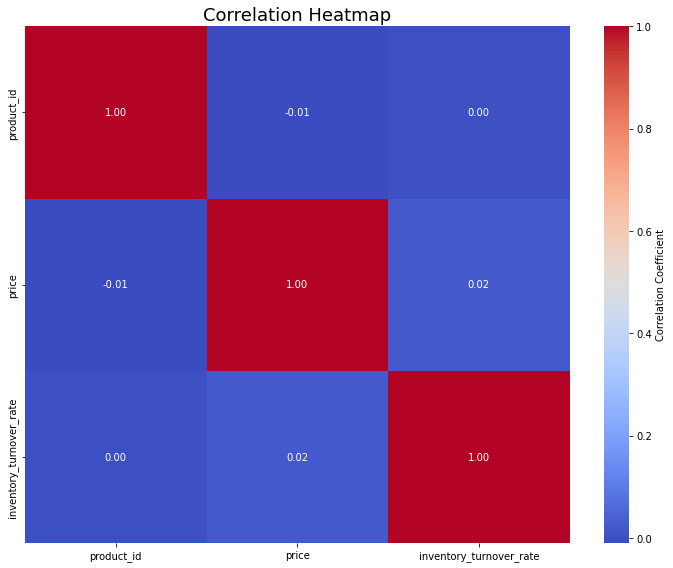

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Select only the numerical columns from the DataFrame for correlation
numerical_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = merged_df[numerical_columns].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})

# Add titles and labels
plt.title('Correlation Heatmap', fontsize=18)
plt.tight_layout()
plt.show()

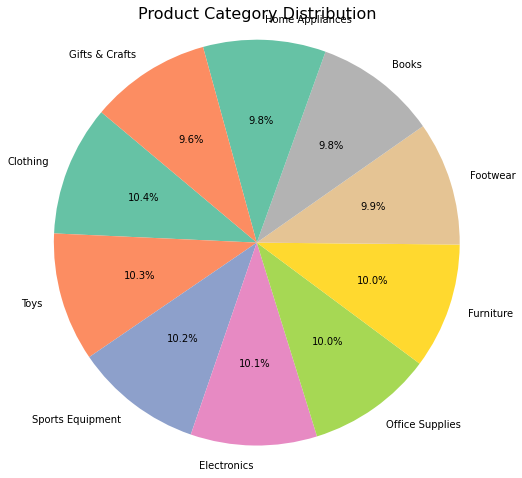

/tmp/ipykernel_5165/3925511565.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, y='category', order=category_counts.index, palette="Set2")


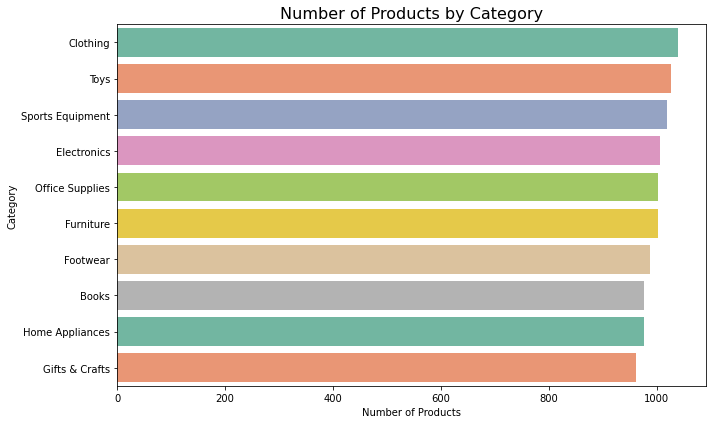

/tmp/ipykernel_5165/3925511565.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_turnover_sum.values, y=category_turnover_sum.index, palette="coolwarm")


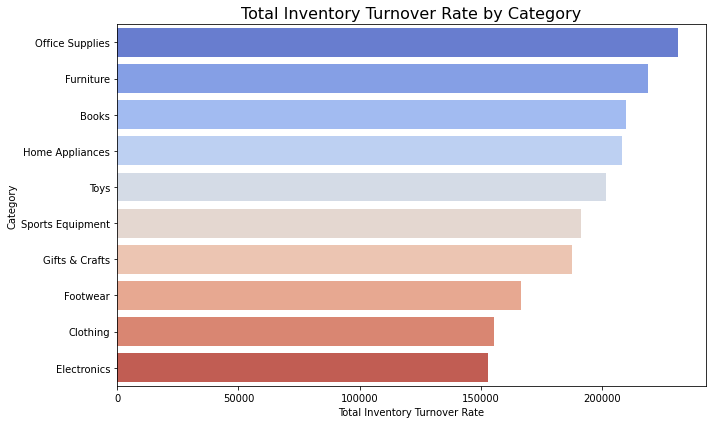

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Pie Chart: Distribution of categories
category_counts = merged_df['category'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2", len(category_counts)))
plt.title('Product Category Distribution', fontsize=16)
plt.axis('equal')  
plt.show()

# Count Plot: Number of products per category
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_df, y='category', order=category_counts.index, palette="Set2")
plt.title('Number of Products by Category', fontsize=16)
plt.xlabel('Number of Products')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

# Bar Plot: Sum of inventory turnover rate per category
category_turnover_sum = merged_df.groupby('category')['inventory_turnover_rate'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=category_turnover_sum.values, y=category_turnover_sum.index, palette="coolwarm")
plt.title('Total Inventory Turnover Rate by Category', fontsize=16)
plt.xlabel('Total Inventory Turnover Rate')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

## Additional Resources
- [Apache Spark Documentation](https://spark.apache.org/documentation.html)
- [Spark Structured Streaming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Optimizing Spark Performance](https://spark.apache.org/docs/latest/tuning.html)
- [Using Spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html)
